# OpenStreetMap 数据研究: 深圳

### 地图范围

深圳，中国 

OSM 数据下载主要有两种来源：

- 从 [Openstreetmap.org](https://www.openstreetmap.org) 中选择任意区域，然后下载一个 XML OSM 数据集。

- 从 [Mapzen.com](https://mapzen.com/) 下载预先选定的城市区域。


报告的深圳 OSM 数据下载自： https://mapzen.com/data/metro-extracts/metro/shenzhen_china/ 


深圳被称作中国的“硅谷”，是一个非常“新”的城市，所以我对深圳十分感兴趣。选择深圳来做分析也有助于我了解这座城市，说不定我将在深圳工作生活。



## 数据清理：深圳 OSM 数据中的问题

通过修改和运行 audit.py 脚本，对深圳的 Open Street Map 数据进行了街道名称、邮政编码的审查，发现了以下几个问题：

- 街道命名：由于是中国城市，所以有的街道名称使用全中文标记，比如“深南大道”、“南海大道”；而有的街道使用了中英文，比如”延芳路 Yanfang Rd“；在使用英文字母上，出现了一些缩写，比如”St“、”Rd“、”BLVD“；还出现了使用拼音的情况，比如”桃园路 Taoyuan Lu“。
- 邮政编码：出现了英文字母开头的邮政编码，经 Google 发现是香港的地段编号

### 不一致的街道命名

街道名称的审查，主要调用了以下几个函数：

```python
def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)
            
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types
```
审查结果节选：

```python
{'599': {'西沙路 Sai Sha Road No. 599'},
 'Au': {'沙頭角公路－石涌凹段 Sha Tau Kok Road – Shek Chung Au'},
 'BLVD': {'Shennan BLVD'},
 'Circuit': {'置福圍 Chi Fuk Circuit', 'Chi Fuk Circuit'},
 'Close': {'置榮徑 Chi Wing Close'},
 'Crescent': {'吉祥街 Kat Cheung Crescent',
              '康樂園市中心徑 Hong Lok Yuen Town Centre Crescent'},
 'DaDao': {'NanHai DaDao'},
 'Dadao': {'南山大道 Nanshan Dadao'},
 'Lu': {'沙河西路 ShaHe Xi Lu', 'XiHuan Lu', '桃园路 Taoyuan Lu', 'KeYuan Lu'},
 'Rd': {'Gongye 7th Rd',
        'Guihua Rd',
        'Houhaibin Rd',
        'Wanghai Rd',
        '中山园路 Zhongshanyuan Rd',
        '延芳路 Yanfang Rd',
        '新秀路 Xinxiu Rd',
        '景田北街 Jingtian N Rd',
        '景田西路 Jingtian W Rd',
        '景田路 Jingtian Rd',
        '欣园路 Xinyuan Rd',
        '比亚迪路 Biyadi Rd',
        '盐田路 Yantian Rd',
        '粤兴三道 Yuexing 3rd Rd',
        '经二路 Jinger Rd',
        '罗芳路 Luofang Rd',
        '莲花路 Lianhua Rd',
        '香梅路 Xiangmei Rd'},
```
发现了一些问题：

- 中英文混用
- 使用缩写
- 使用拼音


于是调用`update_name`函数进行街道名称修改：

```python
mapping = { "St": "Street","St.": "Street","ST": "Street","street":"Street","st": "Street",'Jie':'Street',
            'jie':'Street',
            "Rd": "Road","raod":"Road","road": "Road","Lu":'Road',
            "Ln":"Lane",
            "BLVD": "Boulevard",
            "Acenue": "Avenue", "Ave": "Avenue","avenue": "Avenue", "Av": "Avenue",
            "Hwy": "Highway",
            "Blvd": "Boulevard",
            "Ct": "Court",
            "E": "East","S": "South","W": "West","N": "North",
            "NE": "Northeast","NW": "Northwest","SE": "Southeast","SW": "Southwest",
            "Dadao": "DaDao",
            }
            
def update_name(name, mapping):
    words = name.split()
    for i in range(len(words)):
        if words[i] in mapping:
            words[i] = mapping[words[i]]
    name = " ".join(words)
    return name
```

通过查看打印出的结果，来检查修改是否正确，以下是部分整理后的结果：

```python
景田北街 Jingtian N Rd => 景田北街 Jingtian North Road
Gong ye 7th Rd => Gong ye 7th Road
沙河西路 ShaHe Xi Lu => 沙河西路 ShaHe Xi Road
Fu Shin St => Fu Shin Street
仙湖路 Xianhu St => 仙湖路 Xianhu Street
南山大道 Nanshan Dadao => 南山大道 Nanshan DaDao
Shennan BLVD => Shennan Boulevard
```

可以看到，通过修改，街道名称规范了不少,虽然还是存在一些问题，但足够使用了。



### 邮政编码

通过查阅邮政编码资料得知，深圳的邮政编码是 518000，于是调用`audit_postcode`函数来审查不是以 “518” 开头或不是 6 位数的邮政编码：

```python
def audit_postcode(filename):
    """
    Args: filename that want to be auditted
    Returns: a set of different postcode
    """
    post_code = set();
    for _, element in ET.iterparse(filename):
            if element.tag == "node" or element.tag == "way":
                for tag in element.iter("tag"):
                    if  tag.get('k') == 'addr:postcode' and (len(tag.get('v')) != 6 or tag.get('v')[:3] !='518'):
                    	post_code.add(tag.get('v'))
    return post_code

postcode_set = audit_postcode(OSMFILE)
pprint.pprint(postcode_set)
```
结果节选：

```python
{'00852',
 '516211',
 '51803031',
 'DD101 43',
 'DD105 1269',
 'DD105 1271',
 'DD105 1275',
 'DD105 1312',
 'DD109 754',
 'FSSTL 173',
 'FSSTL 73',
 'NT'}

```
- 出现了大量以字母开头的编码：经 Google 搜索发现这是香港的地段编号
- 个别异常邮编：516211 是广东省惠州市的邮编；00852 则是香港地区的国际区号；51803031 应该是深圳福田地区的邮编，正确是：“518030”


```python
def update_postcode(code):  
    """
    Args: a postcode to be processed
    Returns: a processed postcode
    """
    if code == '51803031' :
        return '518030'
    elif len(code) != 6 or code[:3] != '518' :
        
        return ''

updated_postcode_list =[];
postcode_list = list(postcode_set)
for code in postcode_list:
    updated_postcode_list.append(update_postcode(code))

for i in range(len(postcode_list)):
    print(postcode_list[i], '=>', updated_postcode_list[i])
    
```

调用` update_postcode`对邮政编码进行了两处修改：

- 移除不属于深圳地区的邮政编码：大概是因为在 OpenStreeMap 网站上是使用矩形来划分区域的，所以深圳的地区数据中不可避免地包括了香港和惠州市的数据。
- 将“51803031” 修正成“518030”


###  将清理过的 OSM 数据导入到 SQL 中

运行`data.py`脚本，将清理过的深圳 OSM 数据分别生成 CSV 格式文件，导入到数据库中:


创建数据库｀shenzhen_china.db｀并将 CSV 文件导入

```
$ sqlite3 shenzhen_china.db 

sqlite> .read data_wrangling_schema.sql
sqlite> .mode csv
sqlite> .import nodes.csv nodes
sqlite> .import nodes_tags.csv nodes_tags
sqlite> .import ways.csv ways
sqlite> .import ways_nodes.csv ways_nodes
sqlite> .import ways_tags.csv ways_tags

```


## 数据概述

### 文件大小

通过命令行进行文件大小查询，并打印。由于深圳的 OSM 数据文件已经足够小了，所以我没有生成 sample 文件。

```
$ ls -lh *.csv| awk '{print $5, $9}'
53M nodes.csv
1.6M nodes_tags.csv
4.1M ways.csv
18M ways_nodes.csv
5.8M ways_tags.csv

$ ls -lh shenzhen_china.osm| awk '{print $5, $9}'
135M shenzhen_china.osm

```

### nodes 数量


```sql

SELECT COUNT(*) FROM nodes;

```
670056

###  ways 数量

```sql
SELECT COUNT(*) FROM ways;
```
72711

### 唯一的 users 数量

```sql
SELECT COUNT(DISTINCT(e.uid))
FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) e;
```

802

### Top 10 用户贡献

```sql
SELECT e.user, COUNT(*) as num
FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e
GROUP BY e.user
ORDER BY num DESC
LIMIT 10;   
```

```
MarsmanRom|177022
hlaw|129425
HelioFelix|41073
samho1234567|22037
a1579|21345
jc86035|14633
ch40s|14331
eversone|13678
ssheldonss|12991
katpatuka|12423
```

## 进一步探索城市数据

在中国，深圳是我理想的久居地之一，所以接下来我将从城市建设、生活、宗教等方面来了解它。

### 城市建设

**Top 10 公共设施**

```
SELECT value, COUNT(*) as num FROM nodes_tags 
WHERE key='amenity' 
GROUP BY value 
ORDER BY num DESC 
LIMIT 10;
```

```
toilets|375
restaurant|254
shelter|189
post_box|166
bank|131
parking|111
bus_station|105
fast_food|95
fuel|94
bicycle_parking|86

```

**医院数量**

```sql
SELECT COUNT(*) as num   
FROM nodes_tags                       
WHERE value = 'hospital';   
```
18

**学校数量**

```sql
SELECT COUNT(*) as num   
FROM nodes_tags                       
WHERE value = 'school';   
```
43



### 生活

**Top 10 美食**

```sql
SELECT value, COUNT(*) as num 
FROM nodes_tags
WHERE key = 'cuisine'
GROUP BY value
ORDER BY num DESC
LIMIT 10
```
```
chinese|49
burger|28
chicken|6
coffee_shop|5
japanese|5
local|5
noodle|5
regional|5
cantonese|3
italian|3
```

**Top 10 商店**

```sql
SELECT value, COUNT(*) as num 
FROM nodes_tags
WHERE key = 'shop'
GROUP BY value
ORDER BY num DESC
LIMIT 10;
``` 

```
supermarket|93
convenience|80
yes|43
bakery|19
bicycle|16
chemist|15
mall|14
clothes|12
hairdresser|11
jewelry|11
```


**星巴克数量**


```sql
SELECT COUNT(*) FROM nodes_tags
WHERE value LIKE '%Starbucks%';
```
14




### 宗教

** Top 5 宗教＊＊

```
SELECT nodes_tags.value, COUNT(*) as num
FROM nodes_tags 
JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='place_of_worship') rel
ON nodes_tags.id=rel.id
WHERE nodes_tags.key='religion'
GROUP BY nodes_tags.value
ORDER BY num DESC
LIMIT 5;
```

```
christian|19
buddhist|10
taoist|8
```





### 使用 Pyhton 进行可视化


### 地图编辑热点图

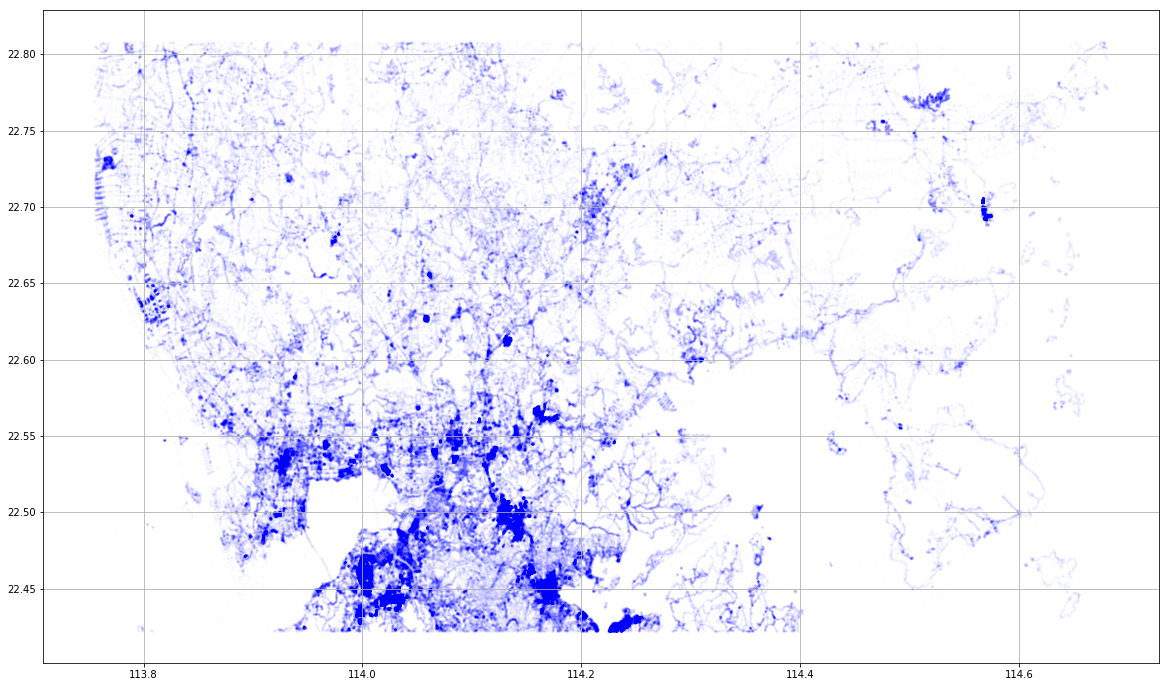

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

nodes = pd.read_csv('nodes.csv')

plt.figure(figsize=(20, 12))
plt.scatter(nodes['lon'], nodes['lat'], marker = '.', s=10, c='blue', alpha=0.01)
plt.grid()
plt.show()

In [ ]:
拥有最丰富 nodes 的在南山区、福田区、罗湖区一带




## 总结


**统一中英文使用方式**

- 深圳和中国其它城市的 OSM 数据都存在的共同问题就是，中英混杂，对于使用 sql 或者 python 之类的分析工具来说，非常不方便。另外，也不利于国外开发者的贡献；
- 一个比较好的规则：只在 "name" 中使用中文，并且尽量提供英文的对照，其它属性如 "key" 等一律使用英文。

优点显而易见，缺点是事实上这个很难实施，特别是深圳的数据比较”脏“，需要很多的时间来改进。


**将 OSM 贡献作为 Uda 的项目评估之一**

- 深圳的地图数据明显地不完善，数据格式混乱，和北京的地图数据对比，数据质量差了非常多。这主要是因为没有那么多参与者提交数据；

- 每个 Uda 学员都挑选了一个城市的 OSM 数据进行清洗，清洗的结果可以利用起来，用于更新 OpenstreetMap 上的数据，这样才是一个良好的生态循环。


我在探索深圳 OSM 数据时发现的主要的问题就数据不完善和混入香港的 OSM 数据，这归结于 OpenStreetMap 一开始划分城市时是通过简单的矩形选区来选取的地图数据的，这也说明了深圳 OSM 还有很大的完善空间，希望有更多的人参与进来。我也将会在项目完成之后尝试去贡献数据。







## Reference

- https://wiki.openstreetmap.org/wiki/Elements
- https://www.w3.org/2001/XMLSchema
- https://github.com/CSMONE/Udacity_Data_Analyst_Nano_Degree_Projects/blob/master/P3_Wrangle_OpenStreetMap_Data
- https://github.com/KwenString/DAND-P3